In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Descriptions

Compute model performance metrics.

# Imports

In [2]:
import datetime
import logging

import core.config as cconfig
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdataframe as hdatafr
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-2362db0d-4090-41a5-ab85-9866ab52ad81.json'
INFO  # Git
  branch_name='CmTask5051_Port_Cx_ProdSystem_to_the_new_style'
  hash='31bf2944a'
  # Last commits:
    * 31bf2944a Nina Lee checkpoint                                                        (   4 hours ago) Thu Aug 24 16:59:26 2023  (HEAD -> CmTask5051_Port_Cx_ProdSystem_to_the_new_style, origin/CmTask5051_Port_Cx_ProdSystem_to_the_new_style)
    * caac00b99 Nina Lee checkpoint                                                        (   4 hours ago) Thu Aug 24 16:42:38 2023           
    *   65f9a7ba3 Nina Lee Merge branch 'master' into CmTask5051_Port_Cx_ProdSystem_to_the_new_style (   5 hours ago) Thu Aug 24 16:23:23 2023           
    |\  
# Machine info
  system=Linux
  node name=c24ced58c9eb
  release=5.15.0-1039-aws
  version=#44~20.04.1-Ubuntu SMP Thu Jun 22 12:21:12 UTC 2023
  machine=x86_64
  processor=x86_64

# Config

In [4]:
config = {
    "dir_name": "/shared_data/model/historical/build_tile_configs.C1b.ccxt_v7_1-all.5T.2019-10-01_2023-02-13.ins/tiled_results/",
    "asset_id_col": "asset_id",
    "dag_builder_name": "C1b",
    "dag_builder_ctor_as_str": "dataflow_orange.pipelines.C1.C1b_pipeline.C1b_DagBuilder",
    "backtest_config": "ccxt_v7_1-all.5T.2019-10-01_2023-02-13",
    "start_date": datetime.date(2019, 10, 1),
    "end_date": datetime.date(2023, 2, 13),
    "metrics": {
        "calculate_hit_rate_kwargs": {
            "alpha": None,
            "method": None,
            "threshold": None,
            "prefix": None,
        },
        "n_quantiles": 10,
        "column_names": {
            "hit": "hit",
            "bar_pnl": "bar_pnl",
        },
    },
}
# Add `Daguilder` column names to the config.
dag_builder = dtfcore.get_DagBuilder_from_string(
    config["dag_builder_ctor_as_str"]
)
dag_config = dag_builder.get_config_template()
column_tags = ["price", "volatility", "target_variable", "prediction"]
config["column_names"] = dag_builder.get_column_names_dict(column_tags)
# Add `vol_adj_returns` column if needed.
# config["column_names"]["vol_adj_returns"] = "target_vwap_ret_0.vol_adj"
# Add start and end dates to the config.
if "start_date" in config:
    hdbg.dassert_in("end_date", config)
else:
    # Extract start and end datetimes from the backtest config.
    hdbg.dassert_in("backtest_config", config)
    backtest_config = config["backtest_config"]
    _, _, time_interval_str = cconfig.parse_backtest_config(backtest_config)
    start_ts, end_ts = cconfig.get_period(time_interval_str)
    config["start_date"] = start_ts.date()
    config["end_date"] = end_ts.date()
# Add time scaling to the metrics config.
freq = dag_config["resample"]["transformer_kwargs"]["rule"]
time_scaling = hdatafr.compute_points_per_year_for_given_freq(freq)
config["metrics"]["time_scaling"] = time_scaling
#
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C1b.ccxt_v7_1-all.5T.2019-10-01_2023-02-13.ins/tiled_results/
asset_id_col: asset_id
dag_builder_name: C1b
dag_builder_ctor_as_str: dataflow_orange.pipelines.C1.C1b_pipeline.C1b_DagBuilder
backtest_config: ccxt_v7_1-all.5T.2019-10-01_2023-02-13
start_date: 2019-10-01
end_date: 2023-02-13
metrics: 
  calculate_hit_rate_kwargs: 
    alpha: None
    method: None
    threshold: None
    prefix: None
  n_quantiles: 10
  column_names: 
    hit: hit
    bar_pnl: bar_pnl
  time_scaling: 105156.125
column_names: 
  price: vwap
  volatility: vwap.ret_0.vol
  target_variable: vwap.ret_0.vol_adj.shift_-2
  prediction: vwap.ret_0.vol_adj.shift_-2_hat


# Load results

In [13]:
# Get data column names to request.
data_cols = list(config["column_names"].to_dict().values())
if config["dag_builder_name"] in ["C3a", "C8b"]:
    # Remove target variable column name for models that do not compute it.
    data_cols.remove(config["column_names"]["target_variable"])

In [14]:
iter_ = dtfmod.yield_processed_parquet_tiles_by_year(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    data_cols,
    asset_ids=None,
)
df_res = hpandas.get_df_from_iterator(iter_)
df_res.head()

  0%|          | 0/5 [00:00<?, ?it/s]

vwap              vwap.ret_0.vol            vwap.ret_0.vol_adj.shift_-2            vwap.ret_0.vol_adj.shift_-2_hat                  vwap                                                                                                                                                                                                                                                   vwap.ret_0.vol                                                                                                                                                                                                                                                   vwap.ret_0.vol_adj.shift_-2                                                                                                                                                                                                                                                   vwap.ret_0.vol_adj.shift_-2_hat                        \
asset_id                  1464553467   1467591036     1464553467 1467591036                  1464553467 1467591036                      1464553467 1467591036 1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                  1030828978 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                      1030828978 1528092593 1776791608   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2019-10-01 00:00:00+00:00        NaN  8282.824049            NaN   0.001509                         NaN  -0.756972                             NaN  -0.022196        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN                             NaN        NaN        NaN   
2019-10-01 00:05:00+00:00        NaN  8245.537329   

# Compute metrics

In [15]:
metric_modes = ["hit_rate", "pnl", "sharpe_ratio"]

## Overall

In [16]:
tag_mode = "all"
stats_all = dtfmod.cross_val_apply_metrics(
    [df_res], tag_mode, metric_modes, config
)
stats_all

INFO  removed rows with nans: 7367 / 6039243 = 0.12%


,hit_rate_point_est_(%),hit_rate_97.50%CI_lower_bound_(%),hit_rate_97.50%CI_upper_bound_(%),total_pnl,SR
all,,,,,
all,51.865224,51.825349,51.905097,8888.756355,9.150719


## Per asset

In [17]:
tag_mode = "full_symbol"
stats_by_symbol = dtfmod.cross_val_apply_metrics(
    [df_res], tag_mode, metric_modes, config
)

INFO  removed rows with nans: 7367 / 6039243 = 0.12%
INFO  backtest_config='ccxt_v7_1-all.5T.2019-10-01_2023-02-13'
INFO  universe_str='ccxt_v7_1-all', trading_period_str='5T', time_interval_str='2019-10-01_2023-02-13'


<Axes: xlabel='full_symbol'>

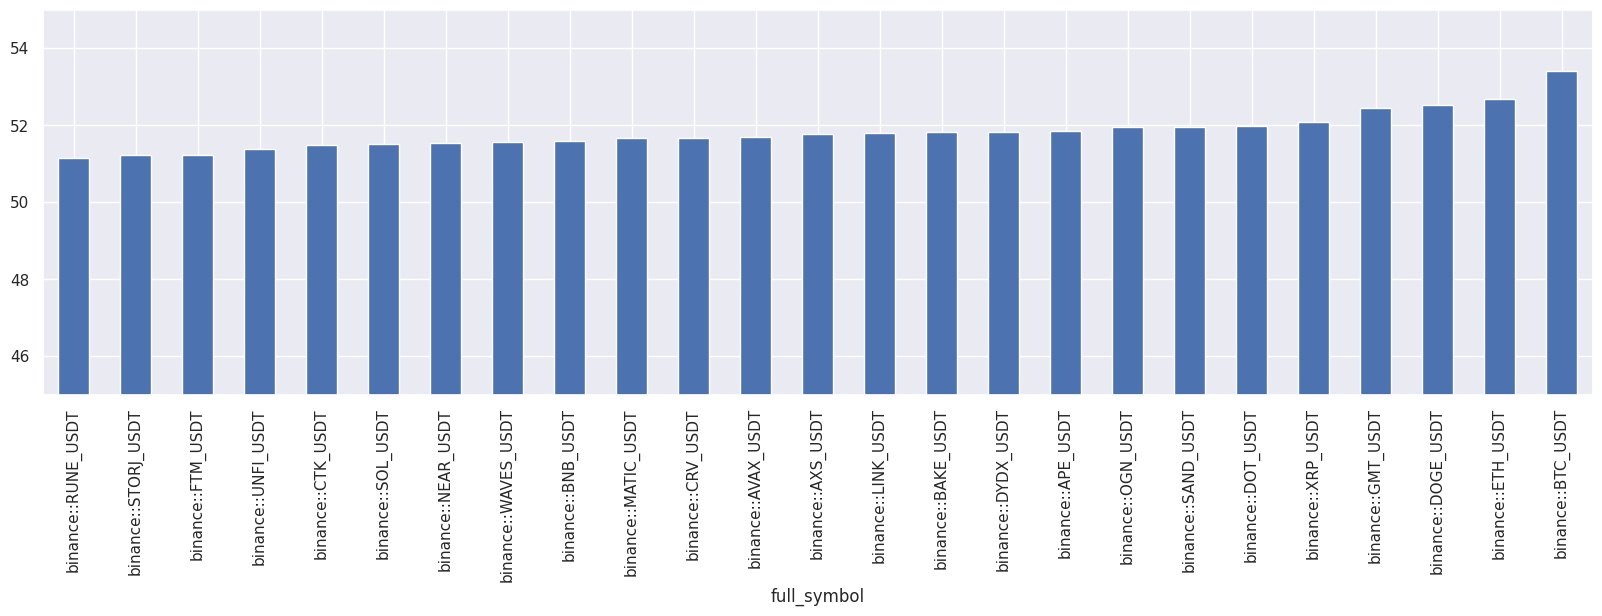

In [18]:
stats_by_symbol["hit_rate_point_est_(%)"].sort_values().plot(
    kind="bar", ylim=(45, 55)
)

<Axes: xlabel='full_symbol'>

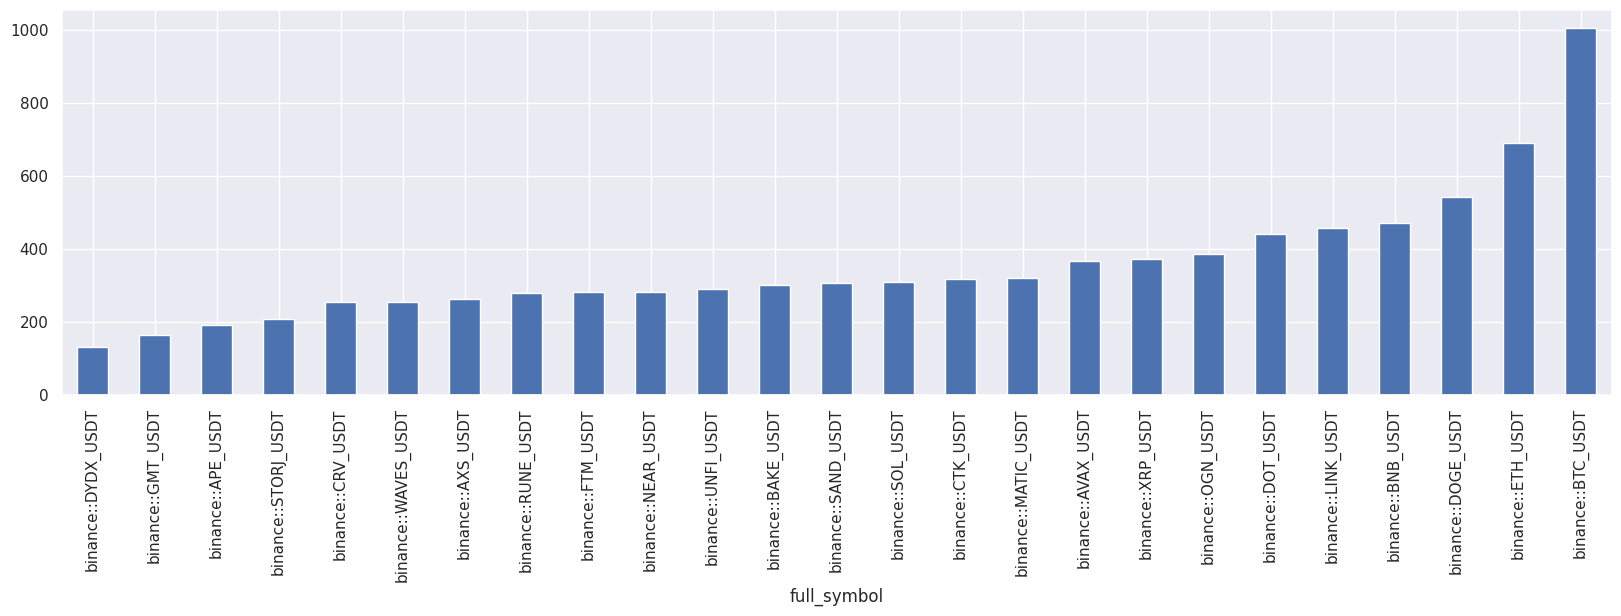

In [19]:
stats_by_symbol["total_pnl"].sort_values().plot(kind="bar")

<Axes: xlabel='full_symbol'>

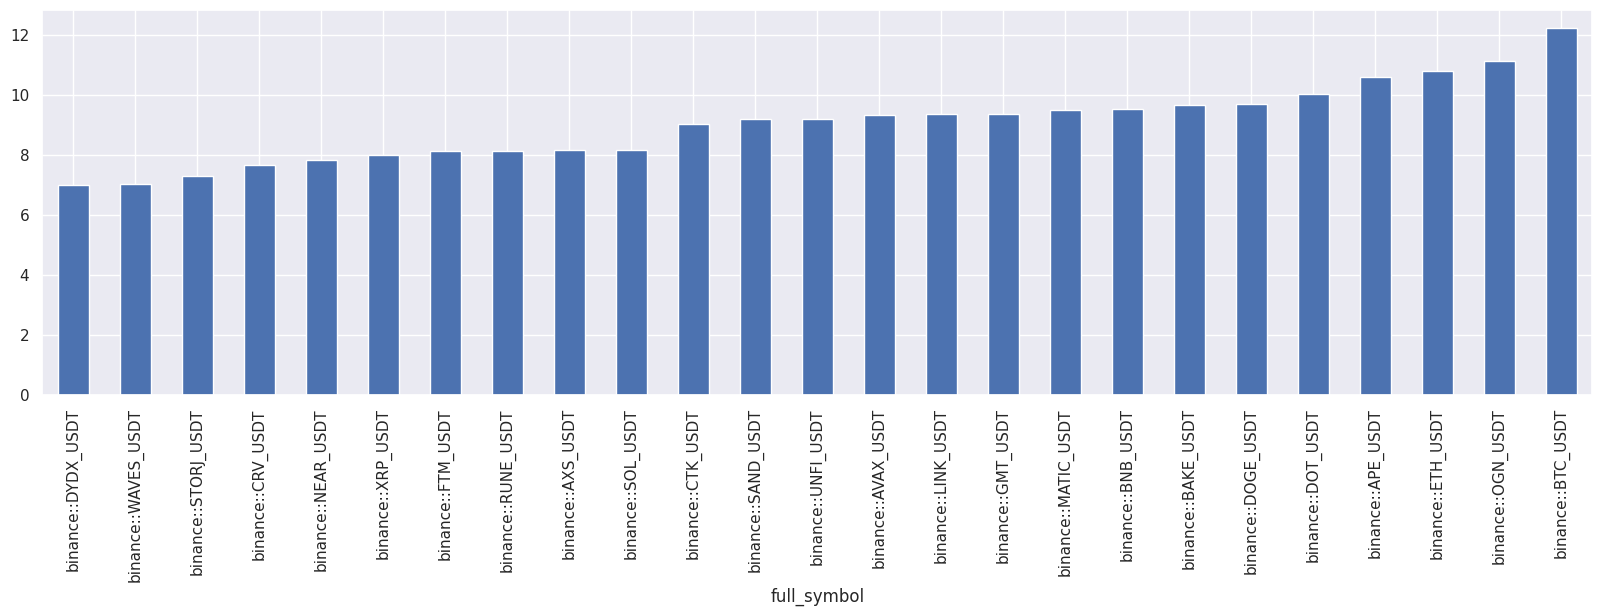

In [20]:
# TODO(Grisha): Seems too big for some assets.
stats_by_symbol["SR"].sort_values().plot(kind="bar")

## Per prediction quantile rank

In [21]:
tag_mode = "prediction_magnitude_quantile_rank"
stats_by_pred_magnitude = dtfmod.cross_val_apply_metrics(
    [df_res], tag_mode, metric_modes, config
)

INFO  removed rows with nans: 7367 / 6039243 = 0.12%


<Axes: xlabel='prediction_magnitude_quantile_rank'>

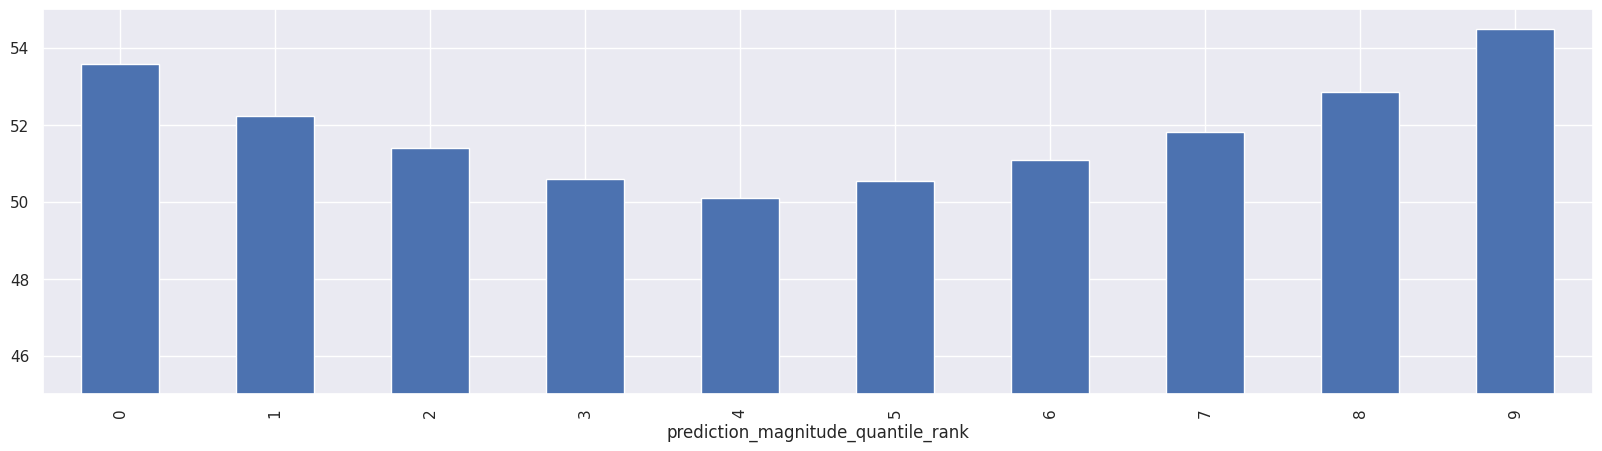

In [22]:
stats_by_pred_magnitude["hit_rate_point_est_(%)"].plot(kind="bar", ylim=(45, 55))

<Axes: xlabel='prediction_magnitude_quantile_rank'>

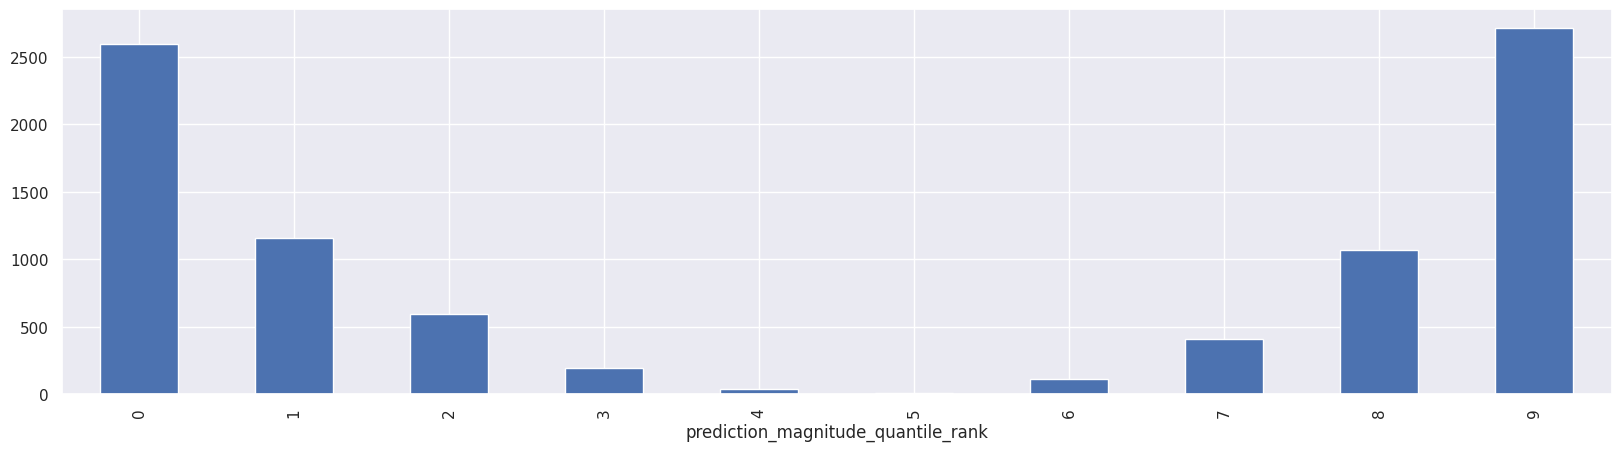

In [23]:
stats_by_pred_magnitude["total_pnl"].plot(kind="bar")

<Axes: xlabel='prediction_magnitude_quantile_rank'>

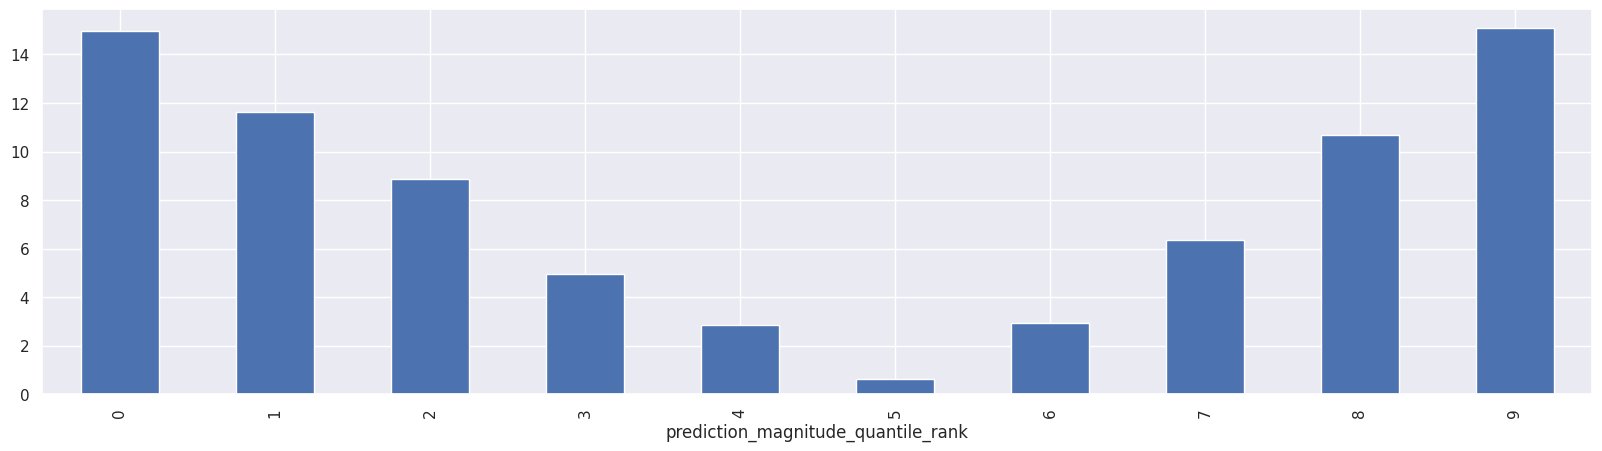

In [24]:
stats_by_pred_magnitude["SR"].plot(kind="bar")